In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## 1. Load All Strategy Data

In [39]:
ENERGY_P30 = 0.30
ENERGY_P50 = 0.50
ENERGY_P100 = 1.00

data_paths = {
    'p100': 'results/simple_20251120_185352/p100/timeseries.csv',
    'round-robin': 'results/simple_20251120_190537/round-robin/timeseries.csv',
    'random': 'results/simple_20251120_191721/random/timeseries.csv',
    'credit-greedy': 'results/simple_20251118_182945_fixed/credit-greedy/timeseries.csv',
    'forecast-aware': 'results/simple_20251118_184912/forecast-aware/timeseries.csv',
    'forecast-aware-global': 'results/simple_20251118_190413/forecast-aware-global/timeseries.csv',
}

strategies = {}
for name, path in data_paths.items():
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    strategies[name] = df
    print(f"Loaded {name}: {len(df)} samples, {df['elapsed_seconds'].max():.1f}s duration")

Loaded p100: 119 samples, 603.1s duration
Loaded round-robin: 119 samples, 602.7s duration
Loaded random: 117 samples, 602.8s duration
Loaded credit-greedy: 118 samples, 601.6s duration
Loaded forecast-aware: 119 samples, 604.2s duration
Loaded forecast-aware-global: 119 samples, 605.0s duration


## 2. Non-Linear Carbon Weighting and Emissions Calculation

In [40]:
def nonlinear_carbon_weight(c):
    """
    Strong non-linear penalty/bonus:
    - Very low carbon: heavily discounted
    - Very high carbon: heavily penalised
    """
    if c <= 0:
        return 0.0
    base = 100.0
    x = c / base
    # Stronger curve: 30 -> ~0.3**0.4 ≈ 0.45, 300 -> 3.0**1.8 ≈ 6.9
    if x >= 1.0:
        return float(x ** 1.8)
    else:
        return float(x ** 0.4)



def calculate_carbon_emissions(df):
    """
    Compute linear and non-linear carbon scores plus temporal metrics for one strategy run.
    """
    # Actual carbon with the strategy's precision distribution (linear model)
    energy_per_slot = (
        df['requests_precision_30'] * ENERGY_P30 +
        df['requests_precision_50'] * ENERGY_P50 +
        df['requests_precision_100'] * ENERGY_P100
    )
    carbon_per_slot = df['carbon_now'] * energy_per_slot

    # Baseline p100 for this exact run (linear model)
    total_requests_per_slot = (
        df['requests_precision_30'] +
        df['requests_precision_50'] +
        df['requests_precision_100']
    )
    baseline_carbon_per_slot = df['carbon_now'] * total_requests_per_slot * ENERGY_P100

    # Non-linear "ethical cost" version: weight each slot by nonlinear_carbon_weight(carbon_now)
    weights = df['carbon_now'].apply(nonlinear_carbon_weight)
    nonlinear_carbon_per_slot = carbon_per_slot * weights
    nonlinear_baseline_per_slot = baseline_carbon_per_slot * weights

    # Mean precision for this run
    total_requests = float(total_requests_per_slot.sum())
    mean_precision = (
        (df['requests_precision_30'] * 0.30 +
         df['requests_precision_50'] * 0.50 +
         df['requests_precision_100'] * 1.00).sum() / max(total_requests, 1.0)
    )

    # Temporal metrics (same as original notebook, using linear carbon)
    precision_per_slot = (
        df['requests_precision_30'] * 0.30 +
        df['requests_precision_50'] * 0.50 +
        df['requests_precision_100'] * 1.00
    ) / total_requests_per_slot.replace(0, 1)

    temporal_metrics = {
        'precision_variance': precision_per_slot.var(),
        'precision_std': precision_per_slot.std(),
        'carbon_variance': carbon_per_slot.var(),
        'credit_balance_std': df['credit_balance'].std() if 'credit_balance' in df.columns else 0.0,
        'credit_balance_range': (df['credit_balance'].max() - df['credit_balance'].min()) if 'credit_balance' in df.columns else 0.0,
    }

    return {
        'total_carbon_linear': float(carbon_per_slot.sum()),
        'baseline_carbon_linear': float(baseline_carbon_per_slot.sum()),
        'carbon_per_slot_linear': carbon_per_slot,
        'total_carbon_nonlinear': float(nonlinear_carbon_per_slot.sum()),
        'baseline_carbon_nonlinear': float(nonlinear_baseline_per_slot.sum()),
        'carbon_per_slot_nonlinear': nonlinear_carbon_per_slot,
        'total_requests': total_requests,
        'mean_precision': float(mean_precision),
        'temporal_metrics': temporal_metrics,
    }



# Compute metrics for all strategies
results = {}
for name, df in strategies.items():
    metrics = calculate_carbon_emissions(df)

    # Linear reduction (same logic as original)
    red_linear = (
        (metrics['baseline_carbon_linear'] - metrics['total_carbon_linear'])
        / metrics['baseline_carbon_linear'] * 100.0
        if metrics['baseline_carbon_linear'] > 0 else 0.0
    )
    # Non-linear reduction (penalises high-carbon slots more)
    red_nonlinear = (
        (metrics['baseline_carbon_nonlinear'] - metrics['total_carbon_nonlinear'])
        / metrics['baseline_carbon_nonlinear'] * 100.0
        if metrics['baseline_carbon_nonlinear'] > 0 else 0.0
    )

    metrics['carbon_reduction_pct_linear'] = red_linear
    metrics['carbon_reduction_pct_nonlinear'] = red_nonlinear
    results[name] = metrics

    print(f"\n{name}:")
    print(f"  Linear total carbon:       {metrics['total_carbon_linear']:,.0f}")
    print(f"  Linear reduction vs p100:  {red_linear:+.2f}%")
    print(f"  Non-linear total carbon:   {metrics['total_carbon_nonlinear']:,.0f}")
    print(f"  Non-linear reduction:      {red_nonlinear:+.2f}%")
    print(f"  Mean precision:            {metrics['mean_precision']:.3f}")
    print(f"  Credit balance std:        {metrics['temporal_metrics']['credit_balance_std']:.4f}")


p100:
  Linear total carbon:       47,653,135
  Linear reduction vs p100:  +0.00%
  Non-linear total carbon:   211,367,024
  Non-linear reduction:      +0.00%
  Mean precision:            1.000
  Credit balance std:        0.0215

round-robin:
  Linear total carbon:       26,034,276
  Linear reduction vs p100:  +39.66%
  Non-linear total carbon:   114,385,174
  Non-linear reduction:      +39.66%
  Mean precision:            0.604
  Credit balance std:        0.1628

random:
  Linear total carbon:       22,095,966
  Linear reduction vs p100:  +41.03%
  Non-linear total carbon:   99,573,567
  Non-linear reduction:      +41.38%
  Mean precision:            0.599
  Credit balance std:        0.1907

credit-greedy:
  Linear total carbon:       27,084,172
  Linear reduction vs p100:  +33.08%
  Non-linear total carbon:   103,254,637
  Non-linear reduction:      +36.96%
  Mean precision:            0.732
  Credit balance std:        0.7627

forecast-aware:
  Linear total carbon:       31,127,

In [41]:
# 3. Build comparison dataframe (linear vs non-linear metrics)
comparison_rows = []
for name, m in results.items():
    precision_loss = 1.0 - m['mean_precision']
    if precision_loss > 0.001:
        eff_linear = m['carbon_reduction_pct_linear'] / (precision_loss * 100.0)
        eff_nonlin = m['carbon_reduction_pct_nonlinear'] / (precision_loss * 100.0)
    else:
        eff_linear = 0.0
        eff_nonlin = 0.0

    precision_cv = (
        m['temporal_metrics']['precision_std'] / m['mean_precision']
        if m['mean_precision'] > 0 else 0.0
)
    qos_predictability = 1.0 / (1.0 + m['temporal_metrics']['credit_balance_std'])

    comparison_rows.append({
        'Strategy': name,
        'Carbon Reduction Linear (%)': m['carbon_reduction_pct_linear'],
        'Carbon Reduction NonLinear (%)': m['carbon_reduction_pct_nonlinear'],
        'Mean Precision': m['mean_precision'],
        'Precision Loss (%)': precision_loss * 100.0,
        'Carbon Efficiency Linear': eff_linear,
        'Carbon Efficiency NonLinear': eff_nonlin,
        'Precision Stability (CV)': precision_cv,
        'QoS Predictability': qos_predictability,
        'Total Requests': m['total_requests'],
    })

comparison_df = pd.DataFrame(comparison_rows)

print("\n=== STRATEGY COMPARISON (Linear vs Non-Linear Carbon) ===")
cols = [
    'Strategy',
    'Carbon Reduction Linear (%)',
    'Carbon Reduction NonLinear (%)',
    'Mean Precision',
    'Precision Loss (%)',
    'Carbon Efficiency Linear',
    'Carbon Efficiency NonLinear',
    'Precision Stability (CV)',
    'QoS Predictability',
]
print(comparison_df[cols].sort_values('Carbon Efficiency NonLinear', ascending=False).to_string(index=False, float_format=lambda x: f"{x:,.3f}"))

print("\n=== ADVANCED (forecast-aware, forecast-aware-global, credit-greedy) ===")
advanced = comparison_df[comparison_df['Strategy'].isin(['forecast-aware', 'forecast-aware-global', 'credit-greedy'])]
if not advanced.empty:
    print(advanced[cols].sort_values('Carbon Efficiency NonLinear', ascending=False).to_string(index=False, float_format=lambda x: f"{x:,.3f}"))
else:
    print("No advanced strategies found in comparison_df")




=== STRATEGY COMPARISON (Linear vs Non-Linear Carbon) ===
             Strategy  Carbon Reduction Linear (%)  Carbon Reduction NonLinear (%)  Mean Precision  Precision Loss (%)  Carbon Efficiency Linear  Carbon Efficiency NonLinear  Precision Stability (CV)  QoS Predictability
       forecast-aware                       35.796                          43.932           0.744              25.557                     1.401                        1.719                     0.239               0.638
forecast-aware-global                       37.228                          42.884           0.719              28.104                     1.325                        1.526                     0.234               0.612
        credit-greedy                       33.081                          36.959           0.732              26.830                     1.233                        1.378                     0.186               0.567
               random                       41.029           

## 4. Visualizing Non-Linear Carbon Efficiency (Advanced Strategies Only)

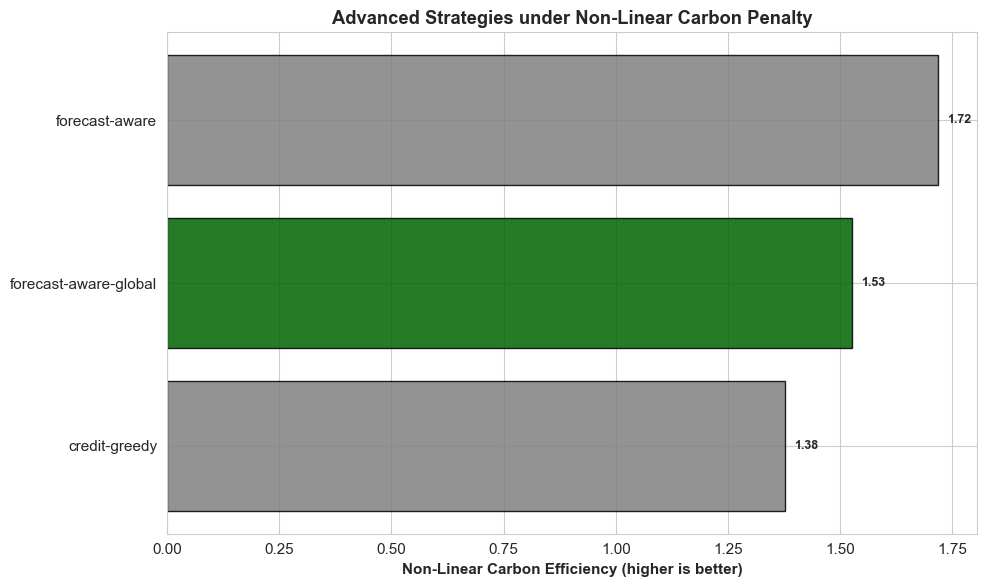

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
advanced = comparison_df[comparison_df['Strategy'].isin(['forecast-aware', 'forecast-aware-global', 'credit-greedy'])]
if advanced.empty:
    print("No advanced strategies found to plot")
else:
    sorted_adv = advanced.sort_values('Carbon Efficiency NonLinear', ascending=True)
    colors = [
        'darkgreen' if s == 'forecast-aware-global' else 'gray'
        for s in sorted_adv['Strategy']
    ]
    bars = ax.barh(sorted_adv['Strategy'], sorted_adv['Carbon Efficiency NonLinear'],
                   color=colors, alpha=0.85, edgecolor='black')
    ax.set_xlabel('Non-Linear Carbon Efficiency (higher is better)', fontweight='bold')
    ax.set_title('Advanced Strategies under Non-Linear Carbon Penalty', fontweight='bold')
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.02, bar.get_y() + bar.get_height()/2, f"{w:.2f}",
                va='center', ha='left', fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()